### This notebook is merely a Proof of Concept (PoC) to show how the background remover works. 

Initially we download the requried dependencies for detectron:

In [1]:
!pip install -U torch==1.10
!pip install cython pyyaml==5.1
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch
print(torch.__version__, torch.cuda.is_available())
from google.colab import drive
drive.mount('/content/drive')
!gcc --version
!pip install detectron2==0.6 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cpu/torch1.10/index.html

1.10.0+cu111 False
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cpu/torch1.10/index.html


We import the libraries from detectron:

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt 

# Detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

We initialize the model and download a pretrained model:

In [3]:
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"
cfg.INPUT.FORMAT = "RGB"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

We define am ethod which removes the background and makes the background white, if possible:

In [4]:
def get_img_no_bg(predictor, image):
      pred = predictor(image)
      mask = pred["instances"].pred_masks
      if (len(mask) == 0):
          return 'empty'
      i = len(mask[0][0])
      j = len(mask[0])
      test = image
      for j1 in range(j):
          for i1 in range(i):
              if (pred["instances"].pred_masks[0][j1][i1] == False):
                  test[j1,i1] = 2
      return test

We take an image from the test dataset and plot it:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


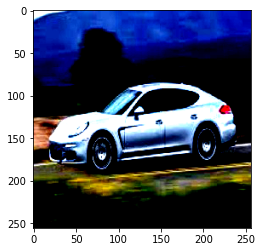

In [5]:
car_img = np.load('/content/drive/MyDrive/data/0_a.npy')[:3]
car_img = np.dstack(car_img)
plt.imshow(car_img)

We now remove the background of the image and show the image after:

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


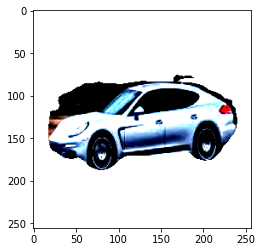

In [6]:
pred = get_img_no_bg(predictor,car_img)
plt.imshow(pred)
plt.show()

So as can be seen this is nowhere near perfect. Detectron2 does not remove all of the background, which is not optimal. Other times it does not even work at all.